In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath("./")))
from ase.build.ribbon import graphene_nanoribbon
from TB.hamiltonian import Hamiltonian
from TB.orbitals import Orbitals
from calc.utils import finite_difference
from TB.hamiltonian_initializer import set_tb_params, set_tb_params_bond_length
import torch
from calc.NEGF import NEGF

In [2]:
from calc.poisson import *
import time
from torch.autograd import grad

nimg = 1000
for l in range(1,30):
    atoms = graphene_nanoribbon(3.5, l, type='armchair', saturated=True)
    pos = torch.from_numpy(atoms.positions)
    density = torch.randn(len(pos)) + 1
    xyz = getImg(n=nimg, coord=pos, d=atoms.positions[:,-1].max(), dim=2)
    density.requires_grad_()
    V_ = density2Potential.apply(xyz, pos, density, nimg, 1.0)
    start = time.time()
    g = grad(V_.sum(), [density])
    end = time.time()
    print(end-start)

0.181046724319458
0.6702597141265869
1.5108749866485596
2.615867853164673
4.192908525466919
4.827371835708618
5.9832329750061035
7.477435827255249
11.6643648147583
14.332530975341797
18.454323291778564
26.707240343093872
28.558669805526733
34.12738394737244
39.03459858894348
38.15781307220459
37.52070927619934
48.89049243927002
56.74631667137146
61.49322581291199
77.2439501285553
83.89748239517212
80.96790170669556
89.03289437294006
92.95836091041565
89.80539321899414
102.52445697784424


: 

: 

[]

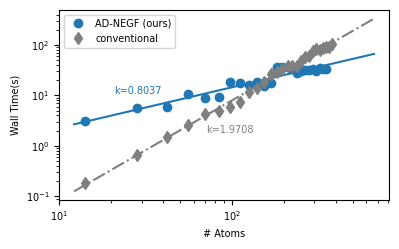

In [82]:
import matplotlib.pyplot as plt
from ase.build.ribbon import graphene_nanoribbon
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.size'] = 7
matplotlib.rcParams['pdf.fonttype'] = 42


Torch = [
0.181046724319458,
0.6702597141265869,
1.5108749866485596,
2.615867853164673,
4.192908525466919,
4.827371835708618,
5.9832329750061035,
7.477435827255249,
11.6643648147583,
14.33253097534179,
18.454323291778564,
26.707240343093872,
28.558669805526733,
34.12738394737244,
39.03459858894348,
38.15781307220459,
37.52070927619934,
48.89049243927002,
56.74631667137146,
61.49322581291199,
77.2439501285553,
83.89748239517212,
80.96790170669556,
89.03289437294006,
92.95836091041565,
89.80539321899414,
102.52445697784424,
]

FMM = [
3.087409257888794,
5.672014236450195,
5.812775373458862,
10.749685287475586,
8.706090688705444,
9.200367450714111,
18.59581995010376,
17.502524614334106,
15.99771761894226,
18.607914924621582,
15.139787435531616,
17.723323822021484,
35.765615940093994,
36.720003843307495,
36.18344688415527,
34.100250005722046,
27.762675285339355,
30.3161039352417,
32.12998366355896,
32.488393783569336,
33.9536452293396,
30.44318389892578,
35.126741886138916,
33.369986057281494,
33.408674240112305
]
def linear(X, Y, start, end, num):
    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()
    X = torch.stack([X,torch.ones_like(X)], dim=1)
    W = (X.T @ X).inverse() @ X.T @ Y.unsqueeze(1)
    

    x = torch.linspace(start=start, end=end, steps=num)
    y = torch.stack([x, torch.ones_like(x)], dim=1) @ W
    return x, y

fig = plt.figure(figsize=(4,2.5))
na = [len(graphene_nanoribbon(3.5, l, type='armchair', saturated=False)) for l in range(1,26)]
plt.plot(na, FMM, "o", c="tab:blue",label="AD-NEGF (ours)")
x, y = linear(np.log(na), np.log(FMM), start=2.5, end=6.5, num=100)
scale_FMM= (max(y)-min(y)) / (max(x)-min(x))
plt.plot(np.exp(x),np.exp(y), c="tab:blue")

na = [len(graphene_nanoribbon(3.5, l, type='armchair', saturated=False)) for l in range(1,28)]
plt.plot(na, Torch, "d", c="tab:gray", label="conventional")
x, y = linear(np.log(na), np.log(Torch), start=2.5, end=6.5, num=100)
scale_Torch = (max(y)-min(y)) / (max(x)-min(x))
plt.plot(np.exp(x),np.exp(y),"-.", c="tab:gray")
plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.text(20.8, 10.8, str("k=%2.4f" % scale_FMM.item()), c="tab:blue")
plt.text(70.8, 1.8, str("k=%2.4f" % scale_Torch.item()), c="tab:gray")
plt.xlabel("# Atoms")
plt.ylabel("Wall Time(s)")
plt.tight_layout()
plt.savefig("../img/Cost_poisson.pdf", dpi=100)
plt.plot()

In [2]:
from calc.poisson import *
import time
from torch.autograd import grad
from fmm3dpy import lfmm3d
from tqdm import tqdm

timetrack = {"FMM":[], "Torch":[]}
nimg = 1000
for l in tqdm(range(1,25)):
    atoms = graphene_nanoribbon(3.5, l, type='armchair', saturated=True)
    pos = torch.from_numpy(atoms.positions)
    density = torch.randn(len(pos))
    img_density = density.view(-1,1,1).expand(-1,1,nimg)
    img_density = torch.cat([img_density, -img_density, img_density, -img_density], dim=1)
    img_density = img_density.reshape(-1)
    xyz = getImg(n=nimg, coord=pos, d=atoms.positions[:,-1].max(), dim=2)

    start = time.time()
    out = lfmm3d(eps=1e-10, sources=xyz.transpose(1, 0).numpy(), charges=img_density.numpy(), dipvec=None,
                        targets=pos.transpose(1,0).numpy(), pgt=1)
    end = time.time()
    timetrack["FMM"].append(end-start)
    start = time.time()
    out = []
    for i in range(len(pos)):
        out.append(torch.sum(img_density / (xyz - pos[i].unsqueeze(0).repeat(len(xyz), 1)).norm(dim=-1)))
    out = torch.stack(out)
    end = time.time()
    timetrack["Torch"].append(end-start)
    end = time.time()
    # print(end-start)


100%|██████████| 24/24 [16:48<00:00, 42.00s/it]


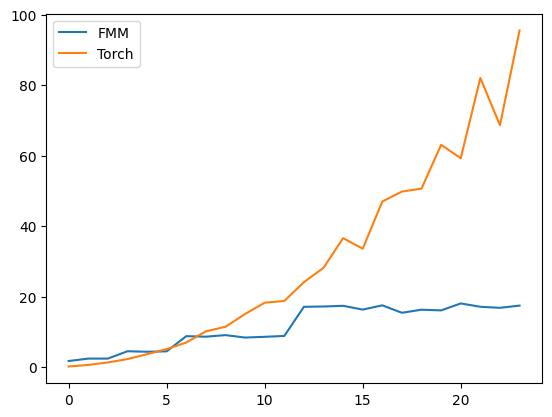

In [6]:
import matplotlib.pyplot as plt

torch.save(obj=timetrack, f="/data/ADNEGF/examples/timecount/FMM_time.pth")

plt.plot(timetrack["FMM"], label="FMM")
plt.plot(timetrack["Torch"], label="Torch")
plt.legend()
# plt.yscale("log")
# plt.xscale("log")
plt.show()

In [8]:
def get_PS2D(pos, V, fix_dim, vslice=0, h=0.1, sigma=0.1, plot=False):

    lx, ly, lz = pos.max(axis=0).values
    sx, sy, sz = pos.min(axis=0).values

    index = {"x":[1,2],"y":[0,2],"z":[0,1]}
    if fix_dim == "x":
        X, Y = torch.arange(sy,ly+h, h), torch.arange(sz,lz+h, h)
        grid = torch.meshgrid(torch.scalar_tensor(vslice), torch.arange(sy,ly+h, h), torch.arange(sz,lz+h, h))
    elif fix_dim == "y":
        X, Y = torch.arange(sx,lx+h, h), torch.arange(sz,lz+h, h)
        grid = torch.meshgrid(torch.arange(sx,lx+h, h), torch.scalar_tensor(vslice), torch.arange(sz,lz+h, h))
    elif fix_dim == "z":
        X, Y = torch.arange(sx,lx+h, h), torch.arange(sy,ly+h, h)
        grid = torch.meshgrid(torch.arange(sx,lx+h, h), torch.arange(sy,ly+h, h), torch.scalar_tensor(vslice))
    else:
        log.error("The fix_dim parameters only allow x/y/z.")
        raise ValueError

    grid = torch.stack(grid).view(3,-1).T
    dist = torch.cdist(grid, pos.float(), p=2)**2

    data = (2*torch.pi*sigma)**-0.5 * V.unsqueeze(0) * torch.exp(-dist/(2*sigma**2))

    data = data.sum(dim=1)

    if plot:
        norm = mpl.colors.Normalize(vmin=0., vmax=0.55)
        xmin, xmax = X.min(), X.max()
        ymin, ymax = Y.min(), Y.max()
        ax = plt.axes(xlim=(xmin,xmax), ylim=(ymin,ymax))
        pc = ax.pcolor(X,Y,data.reshape(len(X), len(Y)).T, cmap="Reds", norm=norm)
        plt.colorbar(pc, ax=ax)
        plt.plot()

    return X, Y, data

NameError: name 'get_PS2D' is not defined

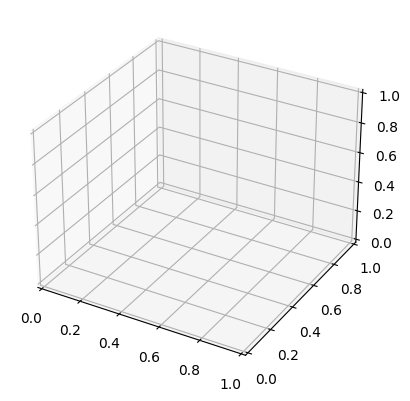

In [3]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# %matplotlib widget

fig = plt.figure()
ax3 = plt.axes(projection='3d')

X, Y, data = get_PS2D(pos=pos, V=density, fix_dim="y", vslice=0, h=0.01, sigma=0.9, plot=False)
XX,YY = np.meshgrid(X,Y)
ZZ = data.reshape(len(X), len(Y)).T.numpy()

# print(XX.shape, YY.shape, ZZ.shape)
ax3.plot_surface(XX,YY,ZZ, cmap='bwr') 

plt.show()

In [62]:
xx = np.arange(-5,5,0.5)
yy = np.arange(-5,5,0.1)
X, Y = np.meshgrid(xx, yy)
Z = np.sin(X)+np.cos(Y)

print(X.shape, Y.shape, Z.shape)

(100, 20) (100, 20) (100, 20)
